In [1]:
import os, simplejson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cluster_model import ClusterModel
from state_optimization import StateOptimization
from datetime import timedelta
import parameter
import pickle
import seaborn as sns
import integer_programming as ip

In [2]:
with open('../data/station_data/2024 model/v2/tph_4/data.pickle', 'rb') as f:
    station_data = pickle.load(f)
    
with open('../station_information.json', 'r') as f:
    station_information = simplejson.load(f)['data']['stations']
    
with open('../data/ideal_states/bounds.pickle', 'rb') as f:
    bounds = pickle.load(f)

# path = '../data/station_data/status_at_time/2024_6_20_2:19.csv'
# time = timedelta(hours=6)
# length = timedelta(hours=2)
tph = 4
square_size = 0.005

In [3]:
model = ClusterModel(station_data=station_data, in_transit=[], tph=tph)
model.init_clusters(square_length=square_size)

model_2 = ClusterModel(station_data=station_data, in_transit=[], tph=4)
model_2.init_clusters(square_length=square_size)

day = 15
start_df = parameter.get_state_df(station_information, f'rebalancing/data/{day}/2024-07-{day}-09-00.pickle')
end_df = parameter.get_state_df(station_information, f'rebalancing/data/{day}/2024-07-{day}-10-00.pickle')
model.init_df_state(start_df, time=timedelta(hours=6))
model_2.init_df_state(end_df, time=timedelta(hours=6))

original_state = {i: model.cluster_dict[i].curr_bikes for i in model.cluster_dict}
end_state = {i: model_2.cluster_dict[i].curr_bikes for i in model_2.cluster_dict}
original_clusters = {cluster.name: cluster for cluster in model.cluster_dict.values()}

state_optimization = StateOptimization(model)


36 horizontal squares and 51 vertical squares. Total squares: 1836
36 horizontal squares and 51 vertical squares. Total squares: 1836


In [4]:
for cluster in model.cluster_dict.values():
    cluster.rate = [rate*1.65 for rate in cluster.rate]
# model.init_by_3()


In [5]:
def get_mape(state_1, state_2):
    mape = 0
    for cluster in state_1:
        max_docks = state_1[cluster].max_docks
        if max_docks == 0:
            continue
        if type(state_2[cluster]) is np.int64:
            mape += abs(state_1[cluster].curr_bikes - state_2[cluster])/max_docks
        else:
            mape += abs(state_1[cluster].curr_bikes - state_2[cluster].curr_bikes)/state_1[cluster].max_docks
    return mape/len(state_1)

In [67]:
print('Initial MSE to end state', model.mean_sq_error(model.cluster_dict, end_state))
print('MSE from origin state:', model.mean_sq_error(model.cluster_dict, original_state))
print('Total trips:', model.total_trips)
origin_mse = []
live_mse = []
end_mse = []
total_trips = []
mape = []
mape_origin = []
time = []

while model.curr_time < timedelta(hours=22):
    model.sim_by_3()
    # model.sim()
    print('Current time:', model.curr_time)
    time.append(model.curr_time)
    # print('Total trips:', model.total_trips)
    total_trips.append(model.total_trips)
    # print('MSE from origin state:', model.mean_sq_error(model.cluster_dict, original_state))
    end_mse.append(model.mean_sq_error(model.cluster_dict, end_state))
    
    model_day = day
    hour = ((model.curr_time.seconds // 3600) + 4) % 24
    minute = (model.curr_time.seconds%3600) // 60
    
    if 0 <= hour < 6:
        model_day += 1
    if hour < 10:
        hour = f'0{hour}'
    if minute < 10:
        minute = f'0{minute}'
    if model_day < 10:
        model_day = f'0{model_day}'
        
    
    
    if not os.path.exists(f'rebalancing/data/{model_day}/2024-07-{model_day}-{hour}-{minute}.pickle'):
        live_mse.append(model.mean_sq_error(model.cluster_dict, {i : model_2.cluster_dict[i].curr_bikes for i in model_2.cluster_dict}))
        origin_mse.append(model_2.mean_sq_error(model_2.cluster_dict, original_state))
        # mape.append(get_mape(model.cluster_dict, model_2.cluster_dict))
        # mape_origin.append(get_mape(model_2.cluster_dict, original_state))
        continue
    
    live_df = parameter.get_state_df(station_information, f'rebalancing/data/{model_day}/2024-07-{model_day}-{hour}-{minute}.pickle')
    model_2.init_df_state(live_df, time=timedelta(hours=(int(hour)+int(minute)/60)))
    live_mse_data = model.mean_sq_error(model.cluster_dict, {i : model_2.cluster_dict[i].curr_bikes for i in model_2.cluster_dict})
    live_mse.append(live_mse_data)
    origin_mse.append(model_2.mean_sq_error(model_2.cluster_dict, original_state))
    # mape_origin.append(get_mape(model_2.cluster_dict, original_state))
    # mape.append(get_mape(model.cluster_dict, model_2.cluster_dict))
    # print('model MSE to live state:', live_mse_data)


print('MSE from origin state:', model.mean_sq_error(model.cluster_dict, original_state))
print('Model MSE to end state', model.mean_sq_error(model.cluster_dict, {i : model_2.cluster_dict[i].curr_bikes for i in model_2.cluster_dict}))
print('Total trips:', model.total_trips)

Initial MSE to end state 0.0
MSE from origin state: 0.0
Total trips: 0
Current time: 6:05:00
Current time: 6:10:00
Current time: 6:15:00
Current time: 6:20:00
Current time: 6:25:00
Current time: 6:30:00
Current time: 6:35:00
Current time: 6:40:00
Current time: 6:45:00
Current time: 6:50:00
Current time: 6:55:00
Current time: 7:00:00
Current time: 7:05:00
Current time: 7:10:00
Current time: 7:15:00
Current time: 7:20:00
Current time: 7:25:00
Current time: 7:30:00
Current time: 7:35:00
Current time: 7:40:00
Current time: 7:45:00
Current time: 7:50:00
Current time: 7:55:00
Current time: 8:00:00
Current time: 8:05:00
Current time: 8:10:00
Current time: 8:15:00
Current time: 8:20:00
Current time: 8:25:00
Current time: 8:30:00
Current time: 8:35:00
Current time: 8:40:00
Current time: 8:45:00
Current time: 8:50:00
Current time: 8:55:00
Current time: 9:00:00
Current time: 9:05:00
Current time: 9:10:00
Current time: 9:15:00
Current time: 9:20:00
Current time: 9:25:00
Current time: 9:30:00
Curre

<Figure size 1000x600 with 0 Axes>

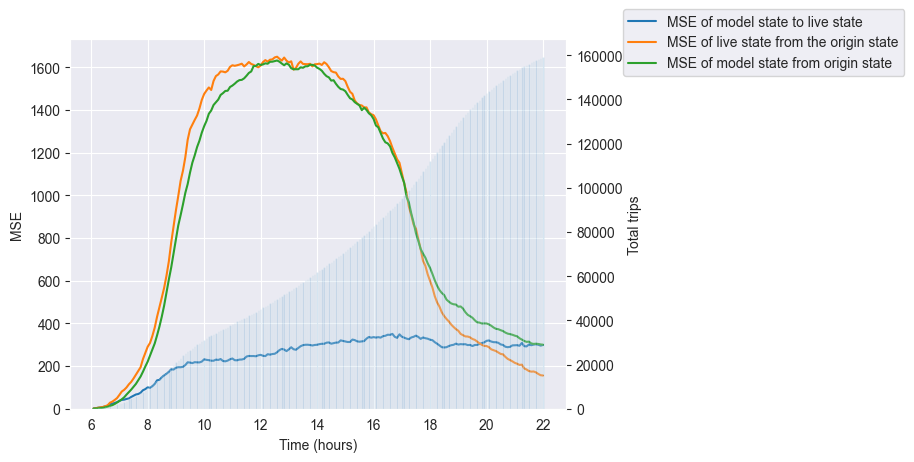

In [69]:
plt.figure(figsize=(10,6))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot([stamp.total_seconds()/3600 for stamp in time], live_mse, label='MSE of model state to live state')
ax1.plot([stamp.total_seconds()/3600 for stamp in time], origin_mse, label='MSE of live state from the origin state')
ax1.plot([stamp.total_seconds()/3600 for stamp in time], end_mse, label='MSE of model state from origin state')
# ax1.plot([stamp.total_seconds()/3600 for stamp in time], mape, label='MAPE of model state to live state')
# ax1.plot([stamp.total_seconds()/3600 for stamp in time], mape_origin, label='MAPE of live state to origin state')
ax2.bar([stamp.total_seconds()/3600 for stamp in time], total_trips, alpha=0.2, label='Total trips', width=0.05)
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('MSE')
ax1.set_ylim(ymin=0)
ax1.legend(bbox_to_anchor=(1.1, 1.1))
# ax1.legend(loc='upper left')
ax2.set_ylabel('Total trips')
ax2.grid(False)
plt.show()


In [85]:
fail_max = 0
fail_cluster = 0
for cluster in model.cluster_dict.values():
    failures = len(cluster.bad_arrivals) + len(cluster.bad_departures)
    if failures > fail_max:
        fail_max = failures
        fail_cluster = cluster.name
        print(fail_max, fail_cluster)
print(fail_max, fail_cluster)

9 24
14 127
15 173
24 269
112 554
251 877
355 1231
355 1231


In [90]:
cluster = model.cluster_dict[877]
fail_arrivals = [trip.start_time.total_seconds()/3600 for trip in cluster.bad_arrivals]
fail_departures = [trip.start_time.total_seconds()/3600 for trip in cluster.bad_departures]
plt.bar(fail_arrivals)

TypeError: bar() missing 1 required positional argument: 'height'

(array([11., 15., 19., 12.,  4.,  9.,  0.,  1.,  6.,  7.]),
 array([16.91666667, 17.18333333, 17.45      , 17.71666667, 17.98333333,
        18.25      , 18.51666667, 18.78333333, 19.05      , 19.31666667,
        19.58333333]),
 <BarContainer object of 10 artists>)

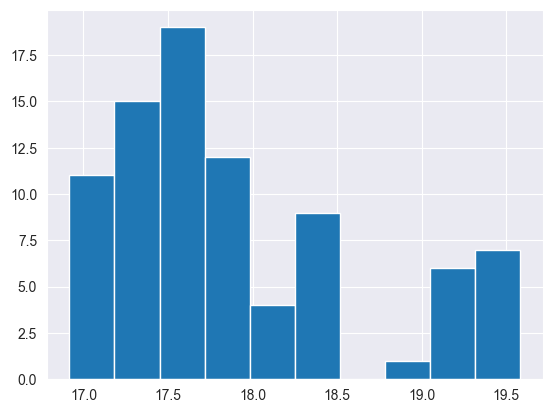

In [89]:
plt.hist(fail_departures)


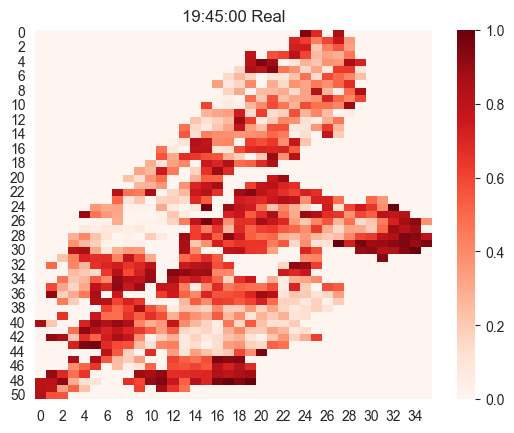

In [5]:
day = 10
files = os.listdir(f'rebalancing/data/{day}')
files.sort()
for i, file in enumerate(files[::3]):
    df = parameter.get_state_df(station_information, f'rebalancing/data/{day}/' + file,)
    split_file = file[:-7].split('-')
    hour = int(split_file[3])-4
    minute = int(split_file[4])
    if not 6 <= hour:
        continue
    # if hour == 20 and minute != 0:
    #     continue
    model_2.init_df_state(df, time=timedelta(hours=(hour+minute/60)))
    if i < 10:
        i = f'00{i}'
    elif i < 100:
        i = f'0{i}'
    else:
        i = f'{i}'
    model_2.show_fill_percent(save=True, name=i, folder='images/fill_2/', title='Real')

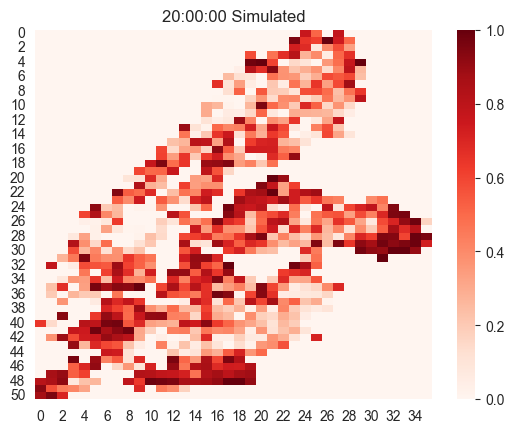

In [6]:
i = 0
while model.curr_time <= timedelta(hours=20):
    if i < 10:
        name = f'00{i}'
    elif i < 100:
        name = f'0{i}'
    else:
        name = f'{i}'
    model.show_fill_percent(save=True, name=name, title='Simulated')
    i += 1
    model.sim()

In [8]:
os.system(f'magick images/fill/*.png fill_sim_9th_6-10.gif')
os.system(f'magick images/fill_2/*.png fill_real_9th_6-10.gif')
os.system('mv fill_sim_9th_6-10.gif gifs/1.gif')
os.system('mv fill_real_9th_6-10.gif gifs/2.gif')

os.system('magick gifs/1.gif -coalesce gifs/a-%04d.gif')     				# split frames of 1.gif into a-0001.gif, a-0002.gif etc
os.system('magick gifs/2.gif -coalesce gifs/b-%04d.gif ')    				# split frames of 2.gif into b-0001.gif, b-0002.gif etc
os.system('for f in gifs/a-*.gif; do magick $f ${f/a/b} +append $f; done') 	# append frames side-by-side
os.system('magick -loop 0 -delay 15 gifs/a-*.gif gifs/result.gif')           

0

In [4]:
# with open('../data/ideal_states/2:19_14h_8steps_0.01sq.pickle', 'rb') as f:
#     opt_state = pickle.load(f)
#     
opt_state = state_optimization.optimize(length=timedelta(hours=4), steps=8)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.5.0 22F66)

CPU model: Intel(R) Core(TM) i9-9980HK CPU @ 2.40GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 138057 rows, 76555 columns and 603654 nonzeros
Model fingerprint: 0xc1731d8f
Variable types: 0 continuous, 76555 integer (38000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 22248 rows and 18014 columns
Presolve time: 2.10s
Presolved: 115809 rows, 58541 columns, 515231 nonzeros
Variable types: 0 continuous, 58541 integer (37908 binary)
Found heuristic solution: objective 357.0000000

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


Interrupt request received
Root barrier log...

Ordering time: 4.27s

Barrier statistics:
 AA' NZ     : 1.649e+06
 Factor NZ

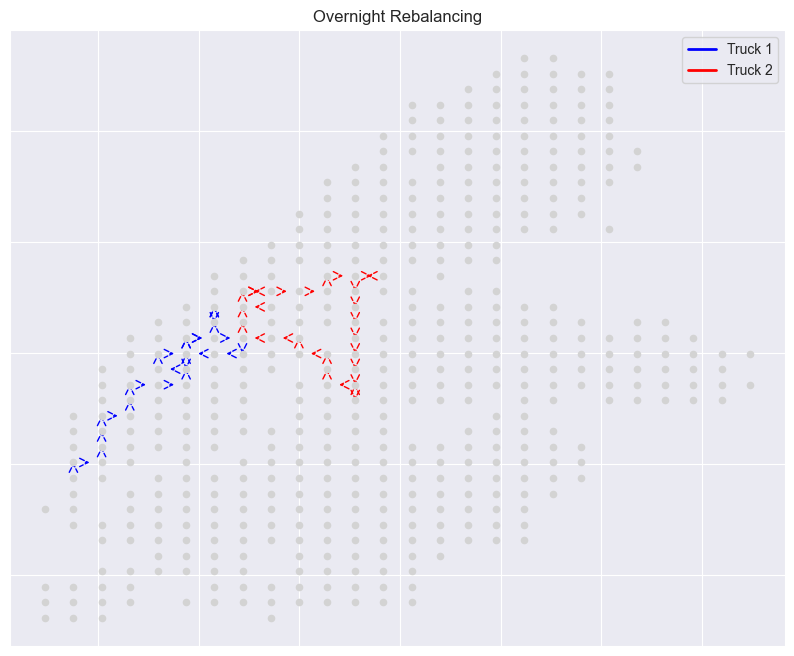

In [6]:
start_levels = {cluster.name: cluster.curr_bikes for cluster in model.cluster_dict.values()}
positions = {cluster.name: (cluster.lon, cluster.lat) for cluster in model.cluster_dict.values()}
adjacency = model.get_adjacent_clusters()
clusters = [cluster for cluster in model.cluster_dict.keys()]
# opt_state = {cluster.name: 2 for cluster in model.cluster_dict.values()}

T = 40
K = 2
L = 30


ip_model, x, y, b = ip.create_model(T=T, K=K, L=L, 
                start_levels=start_levels,
                stations=clusters, 
                optimal_levels=opt_state, 
                positions=positions,  
                neighbors=adjacency)

truck_paths = ip.graph_model(x, b, K, T, clusters, positions)

In [7]:
truck_paths

{1: [(1, 703, '0 bikes'),
  (2, 703, '13 bikes'),
  (3, 677, '13 bikes'),
  (4, 677, '13 bikes'),
  (5, 678, '13 bikes'),
  (6, 652, '13 bikes'),
  (7, 626, '13 bikes'),
  (8, 626, '15 bikes'),
  (9, 600, '15 bikes'),
  (10, 601, '15 bikes'),
  (11, 575, '15 bikes'),
  (12, 549, '15 bikes'),
  (13, 550, '15 bikes'),
  (14, 550, '12 bikes'),
  (15, 551, '12 bikes'),
  (16, 525, '12 bikes'),
  (17, 499, '12 bikes'),
  (18, 473, '12 bikes'),
  (19, 474, '12 bikes'),
  (20, 475, '12 bikes'),
  (21, 501, '12 bikes'),
  (22, 500, '12 bikes'),
  (23, 499, '12 bikes'),
  (24, 525, '12 bikes'),
  (25, 524, '12 bikes'),
  (26, 524, '12 bikes'),
  (27, 498, '12 bikes'),
  (28, 498, '12 bikes'),
  (29, 499, '12 bikes'),
  (30, 499, '12 bikes'),
  (31, 473, '12 bikes'),
  (32, 473, '12 bikes'),
  (33, 474, '12 bikes'),
  (34, 448, '12 bikes'),
  (35, 448, '12 bikes'),
  (36, 422, '12 bikes'),
  (37, 422, '0 bikes'),
  (38, 448, '0 bikes'),
  (39, 448, '0 bikes'),
  (40, 422, '0 bikes')],
 2: [(1, 4

In [9]:
steps = 8
for min in [1.4]:
    print('min:', min)
    model.reset_state(bike_state=original_state,in_transit=[], time=timedelta(hours=6))
    opt_state = state_optimization.optimize(length=timedelta(hours=14), steps=steps, min=min)
    avg_failures = 0
    avg_trips = 0
    for i in range(10):
        model.reset_state(bike_state=opt_state,in_transit=[], time=timedelta(hours=6))
        for j in range(14*4):
            model.sim()
        avg_trips += model.total_trips
        avg_failures += model.failures
    print('Steps:', steps, 'Failures:', avg_failures/10, 'Trips:', avg_trips/10, 'Total bikes', sum([model.cluster_dict[i].curr_bikes for i in model.cluster_dict])+len(model.in_transit))

min: 1.4
Step 1 of 8 completed 9948 failures
Step 2 of 8 completed 9579 failures
Step 3 of 8 completed 5200 failures
Step 4 of 8 completed 3915 failures
Step 5 of 8 completed 3600 failures
Step 6 of 8 completed 3829 failures
Step 7 of 8 completed 3337 failures
Step 8 of 8 completed 3397 failures
Steps: 8 Failures: 3387.3 Trips: 145040.2 Total bikes 33283


In [10]:
model.reset_state(bike_state=original_state,in_transit=[], time=timedelta(hours=6))
for j in range(14*4):
    model.sim()
model.failures

11594

In [13]:
((11594-3387)/11594)

0.707866137657409

In [ ]:
steps = 8
for step in range(steps+1):
    print((steps-step)/(2*steps))
    

In [14]:
dragomir

{24: [0.2857142857142857, 0.6666666666666666],
 25: [0.05952380952380952, 0.8214285714285714],
 27: [0.22, 0.84],
 59: [0.3, 0.5],
 60: [0.045454545454545456, 0.696969696969697],
 61: [0.1590909090909091, 0.9772727272727273],
 62: [0.45, 0.7],
 63: [0.12903225806451613, 0.8064516129032258],
 64: [0.11904761904761904, 0.5238095238095238],
 95: [0.15873015873015872, 0.7142857142857143],
 96: [0.17073170731707318, 0.9024390243902439],
 97: [0.2894736842105263, 0.7105263157894737],
 98: [0.3225806451612903, 0.5161290322580645],
 99: [0.2, 0.6222222222222222],
 100: [0.2222222222222222, 0.8024691358024691],
 127: [0.21052631578947367, 0.21052631578947367],
 129: [0.42857142857142855, 0.7142857142857143],
 130: [0.14925373134328357, 0.8208955223880597],
 131: [0.047619047619047616, 0.8333333333333334],
 132: [0.35, 0.675],
 133: [0.3, 0.6833333333333333],
 134: [0.11538461538461539, 0.6730769230769231],
 135: [0.2, 0.5777777777777777],
 136: [0.23728813559322035, 0.576271186440678],
 163: [0

In [49]:
max_docks = model.get_max_docks_in_clusters()
# avg_fill = [(dragomir[i][1]) if i in dragomir else 0 for i in range(len(model.clusters))]

avg_fill = [(dragomir[i][1] - dragomir[i][0]) if i in dragomir else 0 for i in range(len(model.clusters))]
avg_fill = np.array(avg_fill).reshape(model.vertical_squares, model.horizontal_squares)
mask_specific_color = max_docks != 0

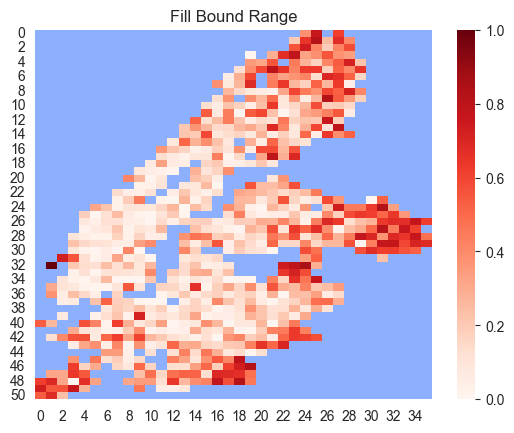

In [52]:
sns.heatmap(avg_fill, cmap='Reds', cbar=True, vmin=0, vmax=1)
sns.heatmap(avg_fill, mask=mask_specific_color, cmap='coolwarm', vmin=-4, vmax=12, cbar=False)
plt.title('Fill Bound Range')
plt.show()

In [35]:
dif = [(bounds[i]['min'] + bounds[i]['max'])/2 - original_state[i] if i in bounds else 0 for i in range(len(model.clusters))]
dif = np.array(dif).reshape(model.vertical_squares, model.horizontal_squares)

In [36]:
max_docks = model.get_max_docks_in_clusters()
mask_specific_color = max_docks != 0
max_docks[max_docks == 0] = 1
percent_diff = dif/max_docks

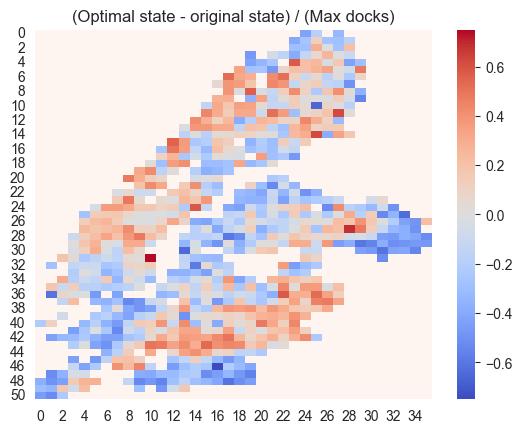

In [37]:
sns.heatmap(percent_diff, cmap='coolwarm', cbar=True, vmin=-0.75, vmax=0.75)
sns.heatmap(percent_diff, mask=mask_specific_color, cmap='Reds', cbar=False)
plt.title('(Optimal state - original state) / (Max docks)')
plt.show()

In [49]:
model.init_df_state(start_df, time=timedelta(hours=6))
original_state = state_optimization.optimize(length=timedelta(hours=14), steps=4)
model.reset_state(original_state, in_transit=[], time=timedelta(hours=6))

Step 1 of 4 completed 10574 failures
Step 2 of 4 completed 6193 failures
Step 3 of 4 completed 4858 failures
Step 4 of 4 completed 5301 failures


In [50]:
bounded = {i: {'min': 0, 'max': model.cluster_dict[i].max_docks} for i in model.cluster_dict}
max_found = {i: False for i in model.cluster_dict}
states_altered = 0

for step in range(1, 6):
    opt_state = state_optimization.optimize(length=timedelta(hours=14), steps=int(24/(2+step)))
    for i in original_state:
        if not max_found[i] and opt_state[i] < original_state[i]:
            bounded[i]['max'] = opt_state[i]
            max_found[i] = True
            states_altered += 1
        elif max_found[i]:
            opt_state[i] = bounded[i]['max']
    num_max = sum([max_found[i] for i in max_found])
    print('Number of max bounds:', num_max, 'out of', len(max_found))
    print('States altered:', states_altered)
    print('-------------------')
    original_state = opt_state
    for i in original_state:
        if not max_found[i]:
            original_state[i] += int((step*model.cluster_dict[i].max_docks)/10)
    model.reset_state(bike_state=original_state, in_transit=[], time=timedelta(hours=6))

for i in original_state:
    if not max_found[i]:
        bounded[i]['max'] = opt_state[i] 
        max_found[i] = True
num_max = sum([max_found[i] for i in max_found])
print('Number of max bounds:', num_max, 'out of', len(max_found))
print('States altered:', states_altered)
print('-------------------')

Step 1 of 8 completed 3636 failures
Step 2 of 8 completed 4617 failures
Step 3 of 8 completed 5627 failures
Step 4 of 8 completed 4616 failures
Step 5 of 8 completed 4448 failures
Step 6 of 8 completed 3985 failures
Step 7 of 8 completed 3514 failures
Step 8 of 8 completed 3713 failures
Number of max bounds: 165 out of 847
States altered: 165
-------------------
Step 1 of 6 completed 5231 failures
Step 2 of 6 completed 4844 failures
Step 3 of 6 completed 5225 failures
Step 4 of 6 completed 4027 failures
Step 5 of 6 completed 4015 failures
Step 6 of 6 completed 4136 failures
Number of max bounds: 389 out of 847
States altered: 389
-------------------
Step 1 of 4 completed 6732 failures
Step 2 of 4 completed 6443 failures
Step 3 of 4 completed 5569 failures
Step 4 of 4 completed 4512 failures
Number of max bounds: 626 out of 847
States altered: 626
-------------------
Step 1 of 4 completed 9957 failures
Step 2 of 4 completed 5586 failures
Step 3 of 4 completed 4878 failures
Step 4 of 4 c

In [51]:
model.init_df_state(start_df, time=timedelta(hours=6))
original_state = state_optimization.optimize(length=timedelta(hours=14), steps=4)
model.reset_state(original_state, in_transit=[], time=timedelta(hours=6))

Step 1 of 4 completed 9015 failures
Step 2 of 4 completed 7124 failures
Step 3 of 4 completed 4968 failures
Step 4 of 4 completed 4004 failures


In [52]:
min_found = {i: False for i in model.cluster_dict}

for step in range(1, 6):
    opt_state = state_optimization.optimize(length=timedelta(hours=14), steps=int(24/(step+2)))
    for i in original_state:
        if not min_found[i] and opt_state[i] > original_state[i]:
            bounded[i]['min'] = opt_state[i]
            min_found[i] = True
            states_altered += 1
        elif min_found[i]:
            opt_state[i] = bounded[i]['min']
    num_min = sum([min_found[i] for i in min_found])
    print('Number of min bounds:', num_min, 'out of', len(min_found))
    print('States altered:', states_altered)
    print('-------------------')
    original_state = opt_state
    for i in original_state:
        if not min_found[i]:
            original_state[i] -= int((step*model.cluster_dict[i].max_docks)/10)
    model.reset_state(bike_state=original_state, in_transit=[], time=timedelta(hours=6))
    
for i in original_state:
    if not min_found[i]:
        bounded[i]['min'] = opt_state[i] 
        min_found[i] = True
        
num_min = sum([min_found[i] for i in min_found])
num_max = sum([max_found[i] for i in max_found])
print('Number of min bounds:', num_min, 'out of', len(min_found))
print('Number of max bounds:', num_max, 'out of', len(max_found))
print('States altered:', states_altered)
print('-------------------')

Step 1 of 8 completed 3716 failures
Step 2 of 8 completed 4398 failures
Step 3 of 8 completed 4908 failures
Step 4 of 8 completed 5250 failures
Step 5 of 8 completed 4263 failures
Step 6 of 8 completed 4325 failures
Step 7 of 8 completed 4063 failures
Step 8 of 8 completed 3944 failures
Number of min bounds: 295 out of 847
States altered: 1140
-------------------
Step 1 of 6 completed 4180 failures
Step 2 of 6 completed 5621 failures
Step 3 of 6 completed 4548 failures
Step 4 of 6 completed 4322 failures
Step 5 of 6 completed 4571 failures
Step 6 of 6 completed 3774 failures
Number of min bounds: 517 out of 847
States altered: 1362
-------------------
Step 1 of 4 completed 4234 failures
Step 2 of 4 completed 4760 failures
Step 3 of 4 completed 4517 failures
Step 4 of 4 completed 4626 failures
Number of min bounds: 660 out of 847
States altered: 1505
-------------------
Step 1 of 4 completed 5586 failures
Step 2 of 4 completed 5912 failures
Step 3 of 4 completed 5157 failures
Step 4 of 

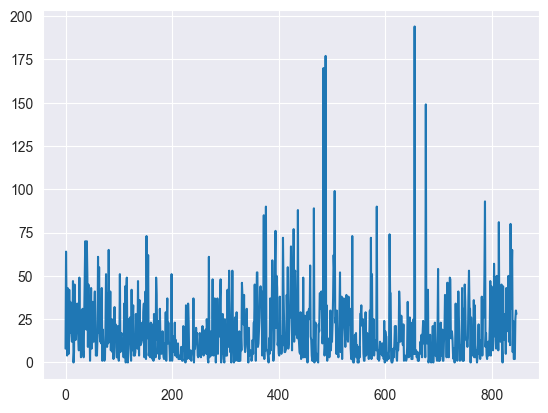

In [56]:
plt.plot([i['max'] - i['min'] for i in bounded.values()])

In [55]:
for i in bounded:
    if bounded[i]['min'] > bounded[i]['max']:
        print(i, bounded[i]['min'], bounded[i]['max'])
        bounded[i]['min'], bounded[i]['max'] = bounded[i]['max'], bounded[i]['min']
        

233 16 15
245 9 5
268 15 7
306 23 16
307 14 12
309 25 23
315 17 6
343 13 6
346 21 15
348 16 14
378 12 8
379 12 11
382 25 19
385 11 0
388 9 6
412 33 30
424 7 6
450 10 6
451 13 8
452 12 8
453 29 23
481 9 5
483 28 16
494 11 9
518 26 12
520 28 24
521 29 22
523 18 15
527 11 9
529 13 12
552 29 26
555 21 8
557 47 42
560 17 15
587 18 9
589 25 18
591 20 18
593 39 30
598 22 11
625 20 19
627 42 36
630 29 21
658 51 47
659 30 17
661 58 55
666 41 39
667 11 9
668 6 2
693 103 94
695 22 21
698 32 11
701 34 14
729 108 78
730 116 114
731 71 63
767 37 32
769 37 30
770 59 53
775 12 2
777 27 15
799 110 93
801 40 37
802 11 5
805 41 24
806 91 80
807 91 88
808 45 37
814 11 4
815 40 26
835 180 175
836 88 63
837 19 0
843 75 62
846 30 19
848 30 26
849 34 21
869 20 12
871 122 117
874 38 23
876 73 25
878 30 21
887 54 50
904 59 45
906 173 150
908 47 25
911 14 1
913 38 37
917 37 31
922 12 11
941 92 83
944 13 0
947 29 9
948 63 59
950 21 14
953 17 14
955 19 14
960 15 14
976 68 64
981 107 63
982 25 18
988 20 14
999 17 1

In [58]:
with open('../data/ideal_states/bounds.pickle', 'wb') as f:
    pickle.dump(bounded, f)

In [11]:
dragomir = {i: [bounded[i]['min'] / model.cluster_dict[i].max_docks, bounded[i]['max']/model.cluster_dict[i].max_docks] if model.cluster_dict[i].max_docks > 0 else [0, 0] for i in bounded}

In [12]:
dragomir

{24: [0.2857142857142857, 0.6666666666666666],
 25: [0.05952380952380952, 0.8214285714285714],
 27: [0.22, 0.84],
 59: [0.3, 0.5],
 60: [0.045454545454545456, 0.696969696969697],
 61: [0.1590909090909091, 0.9772727272727273],
 62: [0.45, 0.7],
 63: [0.12903225806451613, 0.8064516129032258],
 64: [0.11904761904761904, 0.5238095238095238],
 95: [0.15873015873015872, 0.7142857142857143],
 96: [0.17073170731707318, 0.9024390243902439],
 97: [0.2894736842105263, 0.7105263157894737],
 98: [0.3225806451612903, 0.5161290322580645],
 99: [0.2, 0.6222222222222222],
 100: [0.2222222222222222, 0.8024691358024691],
 127: [0.21052631578947367, 0.21052631578947367],
 129: [0.42857142857142855, 0.7142857142857143],
 130: [0.14925373134328357, 0.8208955223880597],
 131: [0.047619047619047616, 0.8333333333333334],
 132: [0.35, 0.675],
 133: [0.3, 0.6833333333333333],
 134: [0.11538461538461539, 0.6730769230769231],
 135: [0.2, 0.5777777777777777],
 136: [0.23728813559322035, 0.576271186440678],
 163: [0

In [117]:
print('min avg', sum([i[0] for i in dragomir.values()])/len(dragomir))
print('max avg', sum([i[1] for i in dragomir.values()])/len(dragomir))

min avg 0.368920921398627
max avg 0.6426683333745278


{24: {'min': 6, 'max': 14},
 25: {'min': 5, 'max': 69},
 27: {'min': 11, 'max': 42},
 59: {'min': 6, 'max': 10},
 60: {'min': 3, 'max': 46},
 61: {'min': 7, 'max': 43},
 62: {'min': 9, 'max': 14},
 63: {'min': 8, 'max': 50},
 64: {'min': 5, 'max': 22},
 95: {'min': 10, 'max': 45},
 96: {'min': 7, 'max': 37},
 97: {'min': 11, 'max': 27},
 98: {'min': 20, 'max': 32},
 99: {'min': 9, 'max': 28},
 100: {'min': 18, 'max': 65},
 127: {'min': 4, 'max': 4},
 129: {'min': 9, 'max': 15},
 130: {'min': 10, 'max': 55},
 131: {'min': 2, 'max': 35},
 132: {'min': 14, 'max': 27},
 133: {'min': 18, 'max': 41},
 134: {'min': 6, 'max': 35},
 135: {'min': 18, 'max': 52},
 136: {'min': 14, 'max': 34},
 163: {'min': 13, 'max': 28},
 164: {'min': 9, 'max': 16},
 165: {'min': 9, 'max': 58},
 167: {'min': 9, 'max': 18},
 168: {'min': 22, 'max': 39},
 169: {'min': 6, 'max': 9},
 170: {'min': 9, 'max': 39},
 171: {'min': 11, 'max': 32},
 172: {'min': 3, 'max': 34},
 173: {'min': 15, 'max': 22},
 198: {'min': 9,